In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
##Load and normzlize the mnist dataset
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset=datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_loader=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(dataset=test_dataset,batch_size=64,shuffle=False)

100%|██████████| 9.91M/9.91M [00:41<00:00, 237kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 107kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 293kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.49MB/s]


In [5]:
iter=iter(train_loader)
images,labels=next(iter)

In [6]:
images.shape

torch.Size([64, 1, 28, 28])

In [7]:
labels.shape

torch.Size([64])

### Training a neural network without batch normalization

In [8]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Flatten(),##Flattens 28*28 array into a flatlist 
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self,x):
        return self.network(x)

In [12]:
def train_model(model,train_loader,test_loader,optimizer,criterion,epochs=5):

    val_accuracies=[]

    for epoch in range(epochs):
        model.train()

        for batch_number,(images,labels) in enumerate(train_loader):
            images=images.to(device)
            labels=labels.to(device)
            #1 feed forward
            optimizer.zero_grad()
            outputs=model(images)
            #2 compute loss
            loss=criterion(outputs,labels)
            #3 backpropogate
            loss.backward()
            #4 update weights
            optimizer.step()
            if batch_number%100==0:
                print(f"Epoch {epoch}, Batch: {batch_number}, Train Loss: {loss.item():0.2f}")

        model.eval()
        y_pred,y_true=[],[]
        with torch.no_grad():
            for images,labels in test_loader:
                images=images.to(device)
                labels=labels.to(device)
                outputs=model(images)
                _,predicted=torch.max(outputs.data,1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        
        val_accuracies.append(accuracy_score(y_true,y_pred))

    return val_accuracies

In [13]:
##Initialize the model,criterion,optimizer
model=MNISTClassifier().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
val_accuracies_no_bn=train_model(model,train_loader,test_loader,optimizer,criterion)

Epoch 0, Batch: 0, Train Loss: 2.29
Epoch 0, Batch: 100, Train Loss: 0.47
Epoch 0, Batch: 200, Train Loss: 0.38
Epoch 0, Batch: 300, Train Loss: 0.26
Epoch 0, Batch: 400, Train Loss: 0.26
Epoch 0, Batch: 500, Train Loss: 0.33
Epoch 0, Batch: 600, Train Loss: 0.11
Epoch 0, Batch: 700, Train Loss: 0.17
Epoch 0, Batch: 800, Train Loss: 0.23
Epoch 0, Batch: 900, Train Loss: 0.05
Epoch 1, Batch: 0, Train Loss: 0.23
Epoch 1, Batch: 100, Train Loss: 0.30
Epoch 1, Batch: 200, Train Loss: 0.27
Epoch 1, Batch: 300, Train Loss: 0.14
Epoch 1, Batch: 400, Train Loss: 0.06
Epoch 1, Batch: 500, Train Loss: 0.12
Epoch 1, Batch: 600, Train Loss: 0.23
Epoch 1, Batch: 700, Train Loss: 0.18
Epoch 1, Batch: 800, Train Loss: 0.23
Epoch 1, Batch: 900, Train Loss: 0.24
Epoch 2, Batch: 0, Train Loss: 0.17
Epoch 2, Batch: 100, Train Loss: 0.08
Epoch 2, Batch: 200, Train Loss: 0.18
Epoch 2, Batch: 300, Train Loss: 0.17
Epoch 2, Batch: 400, Train Loss: 0.10
Epoch 2, Batch: 500, Train Loss: 0.20
Epoch 2, Batch: 60

In [15]:
val_accuracies_no_bn

[0.9328, 0.9559, 0.9617, 0.9643, 0.9673]

In [14]:
##Define a class with batch normalization
class MNISTClassifierWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,10)
        )

    def forward(self,x):
        return self.network(x)

In [16]:
##Initialize the model,criterion,optimizer
model=MNISTClassifierWithBN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
val_accuracies_bn=train_model(model,train_loader,test_loader,optimizer,criterion)

Epoch 0, Batch: 0, Train Loss: 2.38
Epoch 0, Batch: 100, Train Loss: 0.57
Epoch 0, Batch: 200, Train Loss: 0.19
Epoch 0, Batch: 300, Train Loss: 0.23
Epoch 0, Batch: 400, Train Loss: 0.17
Epoch 0, Batch: 500, Train Loss: 0.09
Epoch 0, Batch: 600, Train Loss: 0.13
Epoch 0, Batch: 700, Train Loss: 0.12
Epoch 0, Batch: 800, Train Loss: 0.08
Epoch 0, Batch: 900, Train Loss: 0.09
Epoch 1, Batch: 0, Train Loss: 0.07
Epoch 1, Batch: 100, Train Loss: 0.08
Epoch 1, Batch: 200, Train Loss: 0.09
Epoch 1, Batch: 300, Train Loss: 0.05
Epoch 1, Batch: 400, Train Loss: 0.14
Epoch 1, Batch: 500, Train Loss: 0.10
Epoch 1, Batch: 600, Train Loss: 0.09
Epoch 1, Batch: 700, Train Loss: 0.10
Epoch 1, Batch: 800, Train Loss: 0.04
Epoch 1, Batch: 900, Train Loss: 0.23
Epoch 2, Batch: 0, Train Loss: 0.03
Epoch 2, Batch: 100, Train Loss: 0.11
Epoch 2, Batch: 200, Train Loss: 0.02
Epoch 2, Batch: 300, Train Loss: 0.06
Epoch 2, Batch: 400, Train Loss: 0.19
Epoch 2, Batch: 500, Train Loss: 0.15
Epoch 2, Batch: 60

In [17]:
val_accuracies_bn

[0.9703, 0.9749, 0.975, 0.9765, 0.9748]

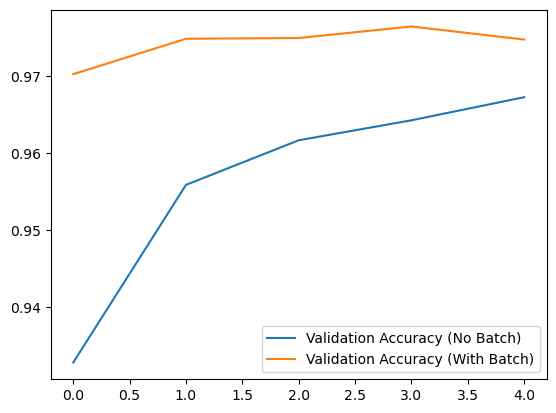

In [18]:
plt.plot(val_accuracies_no_bn, label="Validation Accuracy (No Batch)")
plt.plot(val_accuracies_bn, label="Validation Accuracy (With Batch)")
plt.legend()
plt.show()